# Crowd Instance-level Human Parsing Dataset 数据集上使用DeepLabV3+实现多分类语义分割


作者: [WangXi2016](https://github.com/WangXi2016)

日期: 2022.10.27

摘要: 实现 DeepLabV3+ 架构多类语义分割。

## 一、介绍

语义分割，任务是为图像中的每个像素进行分类，这是一项基本的计算机视觉任务。

在此示例中，我们实现了用于多分类语义分割的DeepLabV3+模型，这是一种全卷积的架构，在语义分割基准测试中表现良好。

## 二、环境设置
导入一些比较基础常用的模块，确认自己的飞桨版本。

In [27]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt
import io
from PIL import Image as PilImage
import paddle
import paddle.nn as nn
from paddle.nn import functional as F

paddle.__version__


'2.3.2'

## 三、数据集


### 3.1 数据集下载

地址：https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz

我们将使用 Crowd 实例级人员解析数据集来训练我们的模型。

Crowd Instance-level Human Parsing Dataset 包含 38，280 个不同的人体图像。
 
CIHP中的每个图像都标有20个类别的像素级注释以及实例级标识。
 
此数据集可用于“人体部位分割”任务。

### 3.2 数据集概览


| Images  | images 2 |
| -------- | -------- | 
| Category_ids: semantic part segmentation labels     | Categories:   visualized semantic part segmentation labels     | 
| Human_ids:    semantic person segmentation labels  | Human:        visualized semantic person segmentation labels |
| Instance_ids: instance-level human parsing labels  | Instances:    visualized instance-level human parsing labels|
  
         
       
       


**Label order of semantic part segmentation:**

1. at
1. air
1. love
1. unglasses
1. pperClothes
1. ress
1. oat
1. ocks
1. ants
1. Torso-skin
1. Scarf
1. Skirt
1. Face
1. Left-arm
1. Right-arm
1. Left-leg
1. Right-leg
1. Left-shoe
1. Right-shoe



In [ ]:
# 解压数据集，此处仅Aistudio环境可直接运行。
!tar -zxvf "data/data129866/instance-level_human_parsing.tar.gz"

In [31]:
DATA_DIR = "./instance-level_human_parsing/Training"
NUM_TRAIN_IMAGES = 1000
NUM_VAL_IMAGES = 50

"""
由于所有文件都是散落在文件夹中，在训练时需要使用的是数据集和标签对应的数据关系，
所以第一步是对原始的数据集进行整理，得到数据集和标签两个数组，分别一一对应。
这样可以在使用的时候能够很方便的找到原始数据和标签的对应关系，否则对于原有的文件夹图片数据无法直接应用。
在这里是用了一个非常简单的方法，按照文件名称进行排序。
"""
train_images = sorted(glob(os.path.join(DATA_DIR, "Images/*")))[:NUM_TRAIN_IMAGES]
train_masks = sorted(glob(os.path.join(DATA_DIR, "Category_ids/*")))[:NUM_TRAIN_IMAGES]
val_images = sorted(glob(os.path.join(DATA_DIR, "Images/*")))[
    NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES
]
val_masks = sorted(glob(os.path.join(DATA_DIR, "Category_ids/*")))[
    NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES
]

# 对数据集进行处理，划分训练集、测试集
def _sort_images(image_dir, image_type):
    """
    对文件夹内的图像进行按照文件名排序
    """
    files = []

    for image_name in os.listdir(image_dir):
        if image_name.endswith('.{}'.format(image_type)) \
                and not image_name.startswith('.'):
            files.append(os.path.join(image_dir, image_name))

    return sorted(files)

def write_file(mode, images, labels):
    with open('./{}.txt'.format(mode), 'w') as f:
        for i in range(len(images)):
            f.write('{}\t{}\n'.format(images[i], labels[i]))

write_file('train', train_images, train_masks)
write_file('val', val_images, val_masks)

### 3.3 PetDataSet数据集抽样展示
划分好数据集之后，来查验一下数据集是否符合预期，通过划分的配置文件读取图片路径后再加载图片数据来用matplotlib进行展示，这里要注意的是对于分割的标签文件因为是1通道的灰度图片，需要在使用imshow接口时注意下传参cmap='gray'。

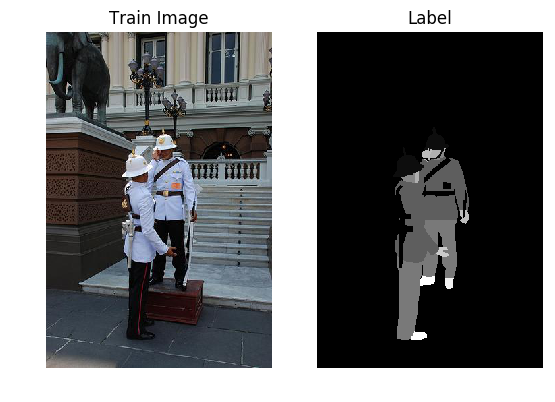

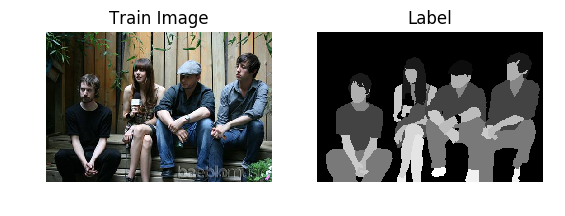

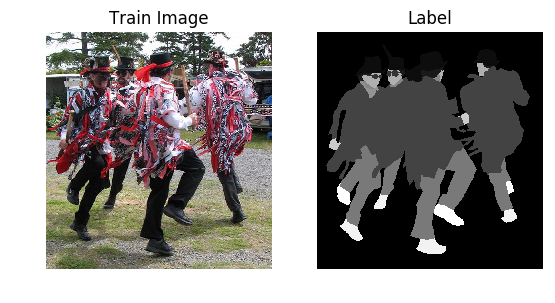

In [24]:
with open('./train.txt', 'r') as f:
    i = 0

    for line in f.readlines():
        image_path, label_path = line.strip().split('\t')
        image = np.array(PilImage.open(image_path))
        label = np.array(PilImage.open(label_path))

        if i > 2:
            break
        # 进行图片的展示
        plt.figure()

        plt.subplot(1,2,1), 
        plt.title('Train Image')
        plt.imshow(image.astype('uint8'))
        plt.axis('off')

        plt.subplot(1,2,2), 
        plt.title('Label')
        plt.imshow(label.astype('uint8'), cmap='gray')
        plt.axis('off')

        plt.show()
        i = i + 1

### 3.4 数据集类定义
飞桨（PaddlePaddle）数据集加载方案是统一使用Dataset（数据集定义） + DataLoader（多进程数据集加载）。

首先进行数据集的定义，数据集定义主要是实现一个新的Dataset类，继承父类paddle.io.Dataset，并实现父类中以下两个抽象方法，__getitem__和__len__：

class MyDataset(Dataset):
    def __init__(self):
        ...

    # 每次迭代时返回数据和对应的标签
    def __getitem__(self, idx):
        return x, y

    # 返回整个数据集的总数
    def __len__(self):
        return count(samples)
在数据集内部可以结合图像数据预处理相关API进行图像的预处理（改变大小、反转、调整格式等）。

由于加载进来的图像不一定都符合自己的需求，举个例子，已下载的这些图片里面就会有RGBA格式的图片，这个时候图片就不符合所需3通道的需求，需要进行图片的格式转换，那么这里直接实现了一个通用的图片读取接口，确保读取出来的图片都是满足需求。

另外图片加载出来的默认shape是HWC，这个时候要看看是否满足后面训练的需要，如果Layer的默认格式和这个不是符合的情况下，需要看下Layer有没有参数可以进行格式调整。不过如果layer较多的话，还是直接调整原数据Shape比较好，否则每个layer都要做参数设置，如果有遗漏就会导致训练出错，那么在本案例中是直接对数据源的shape做了统一调整，从HWC转换成了CHW，因为飞桨的卷积等API的默认输入格式为CHW，这样处理方便后续模型训练。

In [2]:
import random

from paddle.io import Dataset
from paddle.vision.transforms import transforms as T

BATCH_SIZE = 4
NUM_CLASSES = 20
IMAGE_SIZE = (512, 512)

class CIHPDataset(Dataset):
    """
    数据集定义
    """
    def __init__(self, mode='train'):
        """
        构造函数
        """
        self.image_size = IMAGE_SIZE
        self.mode = mode.lower()
        
        assert self.mode in ['train', 'val'], \
            "mode should be 'train' or 'val', but got {}".format(self.mode)
        
        self.train_images = []
        self.label_images = []

        with open('./{}.txt'.format(self.mode), 'r') as f:
            for line in f.readlines():
                image, label = line.strip().split('\t')
                self.train_images.append(image)
                self.label_images.append(label)
        
    def _load_img(self, path, color_mode='rgb', transforms=[]):
        """
        统一的图像处理接口封装，用于规整图像大小和通道
        """
        with open(path, 'rb') as f:
            img = PilImage.open(io.BytesIO(f.read()))
            if color_mode == 'grayscale':
                # if image is not already an 8-bit, 16-bit or 32-bit grayscale image
                # convert it to an 8-bit grayscale image.
                if img.mode not in ('L', 'I;16', 'I'):
                    img = img.convert('L')
            elif color_mode == 'rgba':
                if img.mode != 'RGBA':
                    img = img.convert('RGBA')
            elif color_mode == 'rgb':
                if img.mode != 'RGB':
                    img = img.convert('RGB')
            else:
                raise ValueError('color_mode must be "grayscale", "rgb", or "rgba"')
            
            return T.Compose([
                T.Resize(self.image_size)
            ] + transforms)(img)

    def __getitem__(self, idx):
        """
        返回 image, label
        """
        train_image = self._load_img(self.train_images[idx], 
                                     transforms=[
                                         T.Transpose(), 
                                         T.Normalize(mean=127.5, std=127.5)
                                     ]) # 加载原始图像
        label_image = self._load_img(self.label_images[idx], 
                                     color_mode='grayscale',
                                     transforms=[T.Grayscale()]) # 加载Label图像
    
        # 返回image, label
        train_image = np.array(train_image, dtype='float32')
        label_image = np.array(label_image, dtype='int64')
        return train_image, label_image
        
    def __len__(self):
        """
        返回数据集总数
        """
        return len(self.train_images)

## 四、模型组网

### 4.1 DeepLabv3+ 介绍
 [DeepLabv3+](https://arxiv.org/abs/1802.02611)是DeepLab语义分割系列网络的最新作，其前作有 [DeepLabv1](http://arxiv.org/pdf/1412.7062v3.pdf)，[DeepLabv2](https://arxiv.org/pdf/1606.00915.pdf), [DeepLabv3](https://arxiv.org/abs/1802.02611),
在最新作中，DeepLab的作者通过encoder-decoder进行多尺度信息的融合，同时保留了原来的空洞卷积和ASPP层，
其骨干网络使用了Xception模型，提高了语义分割的健壮性和运行速率，在 PASCAL VOC 2012 dataset取得新的state-of-art performance，89.0mIOU。


![](https://ai-studio-static-online.cdn.bcebos.com/83acbe5790e24e84b3ea4ea8e181421d9f709aa8803e414986d66a40ae0c5cf5)

#### 4.11 ASPP (Atrous Spatial Pyramid Pooling)
通过不同采样率的空洞卷积获取不同尺度的特征信息。具体可参见[DeepLabv2](https://arxiv.org/pdf/1606.00915.pdf)
![](https://ai-studio-static-online.cdn.bcebos.com/39495f7947d24f818d2b988481b7f46f0235b6fcd1134bd4a30ebd3bae3d862c)


### 4.2 辅助函数实现

In [3]:
import os

import paddle
import paddle.nn as nn
import paddle.nn.functional as F


def SyncBatchNorm(*args, **kwargs):
    """In cpu environment nn.SyncBatchNorm does not have kernel so use nn.BatchNorm2D instead"""
    if paddle.get_device() == 'cpu' or os.environ.get('PADDLESEG_EXPORT_STAGE'):
        return nn.BatchNorm2D(*args, **kwargs)
    elif paddle.distributed.ParallelEnv().nranks == 1:
        return nn.BatchNorm2D(*args, **kwargs)
    else:
        return nn.SyncBatchNorm(*args, **kwargs)


class ConvBNReLU(nn.Layer):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 padding='same',
                 **kwargs):
        super().__init__()

        self._conv = nn.Conv2D(
            in_channels, out_channels, kernel_size, padding=padding, **kwargs)

        if 'data_format' in kwargs:
            data_format = kwargs['data_format']
        else:
            data_format = 'NCHW'
        self._batch_norm = SyncBatchNorm(out_channels, data_format=data_format)
        self._relu = Activation("relu")

    def forward(self, x):
        x = self._conv(x)
        x = self._batch_norm(x)
        x = self._relu(x)
        return x



class ConvBN(nn.Layer):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 padding='same',
                 **kwargs):
        super().__init__()
        self._conv = nn.Conv2D(
            in_channels, out_channels, kernel_size, padding=padding, **kwargs)
        if 'data_format' in kwargs:
            data_format = kwargs['data_format']
        else:
            data_format = 'NCHW'
        self._batch_norm = SyncBatchNorm(out_channels, data_format=data_format)

    def forward(self, x):
        x = self._conv(x)
        x = self._batch_norm(x)
        return x



class SeparableConvBNReLU(nn.Layer):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 padding='same',
                 pointwise_bias=None,
                 **kwargs):
        super().__init__()
        self.depthwise_conv = ConvBN(
            in_channels,
            out_channels=in_channels,
            kernel_size=kernel_size,
            padding=padding,
            groups=in_channels,
            **kwargs)
        if 'data_format' in kwargs:
            data_format = kwargs['data_format']
        else:
            data_format = 'NCHW'
        self.piontwise_conv = ConvBNReLU(
            in_channels,
            out_channels,
            kernel_size=1,
            groups=1,
            data_format=data_format,
            bias_attr=pointwise_bias)

    def forward(self, x):
        x = self.depthwise_conv(x)
        x = self.piontwise_conv(x)
        return x



class Activation(nn.Layer):
    def __init__(self, act=None):
        super(Activation, self).__init__()

        self._act = act
        upper_act_names = nn.layer.activation.__dict__.keys()
        lower_act_names = [act.lower() for act in upper_act_names]
        act_dict = dict(zip(lower_act_names, upper_act_names))

        if act is not None:
            if act in act_dict.keys():
                act_name = act_dict[act]
                self.act_func = eval("nn.layer.activation.{}()".format(
                    act_name))
            else:
                raise KeyError("{} does not exist in the current {}".format(
                    act, act_dict.keys()))

    def forward(self, x):
        if self._act is not None:
            return self.act_func(x)
        else:
            return x


class ConvBNLayer(nn.Layer):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 dilation=1,
                 groups=1,
                 is_vd_mode=False,
                 act=None,
                 data_format='NCHW'):
        super(ConvBNLayer, self).__init__()
        if dilation != 1 and kernel_size != 3:
            raise RuntimeError("When the dilation isn't 1," \
                "the kernel_size should be 3.")

        self.is_vd_mode = is_vd_mode
        self._pool2d_avg = nn.AvgPool2D(
            kernel_size=2,
            stride=2,
            padding=0,
            ceil_mode=True,
            data_format=data_format)
        self._conv = nn.Conv2D(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=(kernel_size - 1) // 2 \
                if dilation == 1 else dilation,
            dilation=dilation,
            groups=groups,
            bias_attr=False,
            data_format=data_format)

        self._batch_norm = SyncBatchNorm(
            out_channels, data_format=data_format)
        self._act_op = Activation(act=act)

    def forward(self, inputs):
        if self.is_vd_mode:
            inputs = self._pool2d_avg(inputs)
        y = self._conv(inputs)
        y = self._batch_norm(y)
        y = self._act_op(y)

        return y

### 4.3 backbone实现

In [4]:
class BottleneckBlock(nn.Layer):
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 shortcut=True,
                 if_first=False,
                 dilation=1,
                 data_format='NCHW'):
        super(BottleneckBlock, self).__init__()

        self.data_format = data_format
        self.conv0 = ConvBNLayer(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=1,
            act='relu',
            data_format=data_format)

        self.dilation = dilation

        self.conv1 = ConvBNLayer(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=stride,
            act='relu',
            dilation=dilation,
            data_format=data_format)
        self.conv2 = ConvBNLayer(
            in_channels=out_channels,
            out_channels=out_channels * 4,
            kernel_size=1,
            act=None,
            data_format=data_format)

        if not shortcut:
            self.short = ConvBNLayer(
                in_channels=in_channels,
                out_channels=out_channels * 4,
                kernel_size=1,
                stride=1,
                is_vd_mode=False if if_first or stride == 1 else True,
                data_format=data_format)

        self.shortcut = shortcut
        # NOTE: Use the wrap layer for quantization training
 
        self.relu = Activation(act="relu")

    def forward(self, inputs):
 
        y = self.conv0(inputs)
        conv1 = self.conv1(y)
        conv2 = self.conv2(conv1)
 

        if self.shortcut:
            short = inputs
        else:
            short = self.short(inputs)
        y = short+ conv2
        y = self.relu(y)
        return y


class BasicBlock(nn.Layer):
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 dilation=1,
                 shortcut=True,
                 if_first=False,
                 data_format='NCHW'):
        super(BasicBlock, self).__init__()
        self.conv0 = ConvBNLayer(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=stride,
            dilation=dilation,
            act='relu',
            data_format=data_format)
        self.conv1 = ConvBNLayer(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3,
            dilation=dilation,
            act=None,
            data_format=data_format)

        if not shortcut:
            self.short = ConvBNLayer(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=1,
                stride=1,
                is_vd_mode=False if if_first or stride == 1 else True,
                data_format=data_format)

        self.shortcut = shortcut
        self.dilation = dilation
        self.data_format = data_format

        self.relu = Activation(act="relu")

    def forward(self, inputs):
        y = self.conv0(inputs)
        conv1 = self.conv1(y)

        if self.shortcut:
            short = inputs
        else:
            short = self.short(inputs)
        print(short.shape,conv1.shape)
        y = paddle.add(short, conv1)
        y = self.relu(y)

        return y


class ResNet_vd(nn.Layer):
    """
    The ResNet_vd implementation based on PaddlePaddle.
    The original article refers to Jingdong
    Tong He, et, al. "Bag of Tricks for Image Classification with Convolutional Neural Networks"
    (https://arxiv.org/pdf/1812.01187.pdf).
    Args:
        layers (int, optional): The layers of ResNet_vd. The supported layers are (18, 34, 50, 101, 152, 200). Default: 50.
        output_stride (int, optional): The stride of output features compared to input images. It is 8 or 16. Default: 8.
        multi_grid (tuple|list, optional): The grid of stage4. Defult: (1, 1, 1).
        pretrained (str, optional): The path of pretrained model.
    """

    def __init__(self,
                 layers=50,
                 output_stride=8,
                 multi_grid=(1, 1, 1),
                 pretrained=None,
                 data_format='NCHW'):
        super(ResNet_vd, self).__init__()

        self.data_format = data_format
        self.conv1_logit = None  # for gscnn shape stream
        self.layers = layers
        supported_layers = [18, 34, 50, 101, 152, 200]
        assert layers in supported_layers, \
            "supported layers are {} but input layer is {}".format(
                supported_layers, layers)

        if layers == 18:
            depth = [2, 2, 2, 2]
        elif layers == 34 or layers == 50:
            depth = [3, 4, 6, 3]
        elif layers == 101:
            depth = [3, 4, 23, 3]
        elif layers == 152:
            depth = [3, 8, 36, 3]
        elif layers == 200:
            depth = [3, 12, 48, 3]
        num_channels = [64, 256, 512,
                        1024] if layers >= 50 else [64, 64, 128, 256]
        num_filters = [64, 128, 256, 512]

        # for channels of four returned stages
        self.feat_channels = [c * 4 for c in num_filters
                              ] if layers >= 50 else num_filters

        dilation_dict = None
        if output_stride == 8:
            dilation_dict = {2: 2, 3: 4}
        elif output_stride == 16:
            dilation_dict = {3: 2}

        self.conv1_1 = ConvBNLayer(
            in_channels=3,
            out_channels=32,
            kernel_size=3,
            stride=2,
            act='relu',
            data_format=data_format)
        self.conv1_2 = ConvBNLayer(
            in_channels=32,
            out_channels=32,
            kernel_size=3,
            stride=1,
            act='relu',
            data_format=data_format)
        self.conv1_3 = ConvBNLayer(
            in_channels=32,
            out_channels=64,
            kernel_size=3,
            stride=1,
            act='relu',
            data_format=data_format)
        self.pool2d_max = nn.MaxPool2D(
            kernel_size=3, stride=2, padding=1, data_format=data_format)

        # self.block_list = []
        self.stage_list = []
        if layers >= 50:
            for block in range(len(depth)):
                shortcut = False
                block_list = []
                for i in range(depth[block]):
                    if layers in [101, 152] and block == 2:
                        if i == 0:
                            conv_name = "res" + str(block + 2) + "a"
                        else:
                            conv_name = "res" + str(block + 2) + "b" + str(i)
                    else:
                        conv_name = "res" + str(block + 2) + chr(97 + i)

                    ###############################################################################
                    # Add dilation rate for some segmentation tasks, if dilation_dict is not None.
                    dilation_rate = dilation_dict[
                        block] if dilation_dict and block in dilation_dict else 1

                    # Actually block here is 'stage', and i is 'block' in 'stage'
                    # At the stage 4, expand the the dilation_rate if given multi_grid
                    if block == 3:
                        dilation_rate = dilation_rate * multi_grid[i]
                    ###############################################################################

                    bottleneck_block = self.add_sublayer(
                        'bb_%d_%d' % (block, i),
                        BottleneckBlock(
                            in_channels=num_channels[block]
                            if i == 0 else num_filters[block] * 4,
                            out_channels=num_filters[block],
                            stride=2 if i == 0 and block != 0 and
                            dilation_rate == 1 else 1,
                            shortcut=shortcut,
                            if_first=block == i == 0,
                            dilation=dilation_rate,
                            data_format=data_format))

                    block_list.append(bottleneck_block)
                    shortcut = True
                self.stage_list.append(block_list)
        else:
            for block in range(len(depth)):
                shortcut = False
                block_list = []
                for i in range(depth[block]):
                    dilation_rate = dilation_dict[block] \
                        if dilation_dict and block in dilation_dict else 1
                    if block == 3:
                        dilation_rate = dilation_rate * multi_grid[i]

                    basic_block = self.add_sublayer(
                        'bb_%d_%d' % (block, i),
                        BasicBlock(
                            in_channels=num_channels[block]
                            if i == 0 else num_filters[block],
                            out_channels=num_filters[block],
                            stride=2 if i == 0 and block != 0 \
                                and dilation_rate == 1 else 1,
                            dilation=dilation_rate,
                            shortcut=shortcut,
                            if_first=block == i == 0,
                            data_format=data_format))
                    block_list.append(basic_block)
                    shortcut = True
                self.stage_list.append(block_list)


    def forward(self, inputs):
        y = self.conv1_1(inputs)
        y = self.conv1_2(y)
        y = self.conv1_3(y)
        self.conv1_logit = y.clone()
        y = self.pool2d_max(y)

        # A feature list saves the output feature map of each stage.
        feat_list = []
        for stage in self.stage_list:
            for block in stage:
                y = block(y)
            feat_list.append(y)

        return feat_list


def ResNet18_vd(**args):
    model = ResNet_vd(layers=18, **args)
    return model


def ResNet34_vd(**args):
    model = ResNet_vd(layers=34, **args)
    return model



def ResNet50_vd(**args):
    model = ResNet_vd(layers=50, **args)
    return model



def ResNet101_vd(**args):
    model = ResNet_vd(layers=101, **args)
    return model

### 4.4 DeepLabV3+实现

In [5]:
class ASPPModule(nn.Layer):
    """
    Atrous Spatial Pyramid Pooling.
    Args:
        aspp_ratios (tuple): The dilation rate using in ASSP module.
        in_channels (int): The number of input channels.
        out_channels (int): The number of output channels.
        align_corners (bool): An argument of F.interpolate. It should be set to False when the output size of feature
            is even, e.g. 1024x512, otherwise it is True, e.g. 769x769.
        use_sep_conv (bool, optional): If using separable conv in ASPP module. Default: False.
        image_pooling (bool, optional): If augmented with image-level features. Default: False
    """

    def __init__(self,
                 aspp_ratios,
                 in_channels,
                 out_channels,
                 align_corners,
                 use_sep_conv=False,
                 image_pooling=False,
                 data_format='NCHW'):
        super().__init__()

        self.align_corners = align_corners
        self.data_format = data_format
        self.aspp_blocks = nn.LayerList()

        for ratio in aspp_ratios:
            if use_sep_conv and ratio > 1:
                conv_func = SeparableConvBNReLU
            else:
                conv_func = ConvBNReLU

            block = conv_func(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=1 if ratio == 1 else 3,
                dilation=ratio,
                padding=0 if ratio == 1 else ratio,
                data_format=data_format)
            self.aspp_blocks.append(block)

        out_size = len(self.aspp_blocks)

        if image_pooling:
            self.global_avg_pool = nn.Sequential(
                nn.AdaptiveAvgPool2D(
                    output_size=(1, 1), data_format=data_format),
                ConvBNReLU(
                    in_channels,
                    out_channels,
                    kernel_size=1,
                    bias_attr=False,
                    data_format=data_format))
            out_size += 1
        self.image_pooling = image_pooling

        self.conv_bn_relu = ConvBNReLU(
            in_channels=out_channels * out_size,
            out_channels=out_channels,
            kernel_size=1,
            data_format=data_format)

        self.dropout = nn.Dropout(p=0.1)  # drop rate

    def forward(self, x):
        outputs = []
        if self.data_format == 'NCHW':
            interpolate_shape = paddle.shape(x)[2:]
            axis = 1
        else:
            interpolate_shape = paddle.shape(x)[1:3]
            axis = -1
        for block in self.aspp_blocks:
            y = block(x)
            outputs.append(y)

        if self.image_pooling:
            img_avg = self.global_avg_pool(x)
            img_avg = F.interpolate(
                img_avg,
                interpolate_shape,
                mode='bilinear',
                align_corners=self.align_corners,
                data_format=self.data_format)
            outputs.append(img_avg)

        x = paddle.concat(outputs, axis=axis)
        x = self.conv_bn_relu(x)
        x = self.dropout(x)

        return x

class DeepLabV3P(nn.Layer):
    """
    The DeepLabV3Plus implementation based on PaddlePaddle.
    The original article refers to
     Liang-Chieh Chen, et, al. "Encoder-Decoder with Atrous Separable Convolution for Semantic Image Segmentation"
     (https://arxiv.org/abs/1802.02611)
    Args:
        num_classes (int): The unique number of target classes.
        backbone (paddle.nn.Layer): Backbone network, currently support Resnet50_vd/Resnet101_vd/Xception65.
        backbone_indices (tuple, optional): Two values in the tuple indicate the indices of output of backbone.
           Default: (0, 3).
        aspp_ratios (tuple, optional): The dilation rate using in ASSP module.
            If output_stride=16, aspp_ratios should be set as (1, 6, 12, 18).
            If output_stride=8, aspp_ratios is (1, 12, 24, 36).
            Default: (1, 6, 12, 18).
        aspp_out_channels (int, optional): The output channels of ASPP module. Default: 256.
        align_corners (bool, optional): An argument of F.interpolate. It should be set to False when the feature size is even,
            e.g. 1024x512, otherwise it is True, e.g. 769x769. Default: False.
        pretrained (str, optional): The path or url of pretrained model. Default: None.
        data_format(str, optional): Data format that specifies the layout of input. It can be "NCHW" or "NHWC". Default: "NCHW".
    """

    def __init__(self,
                 num_classes,
                 backbone,
                 backbone_indices=(0, 3),
                 aspp_ratios=(1, 6, 12, 18),
                 aspp_out_channels=256,
                 align_corners=False,
                 pretrained=None,
                 data_format="NCHW"):
        super().__init__()

        self.backbone = backbone
        backbone_channels = [
            backbone.feat_channels[i] for i in backbone_indices
        ]

        self.head = DeepLabV3PHead(
            num_classes,
            backbone_indices,
            backbone_channels,
            aspp_ratios,
            aspp_out_channels,
            align_corners,
            data_format=data_format)

        self.align_corners = align_corners
        self.pretrained = pretrained
        self.data_format = data_format


    def forward(self, x):
        feat_list = self.backbone(x)
        logit_list = self.head(feat_list)
        if self.data_format == 'NCHW':
            ori_shape = paddle.shape(x)[2:]
        else:
            ori_shape = paddle.shape(x)[1:3]
        return [
            F.interpolate(
                logit,
                ori_shape,
                mode='bilinear',
                align_corners=self.align_corners,
                data_format=self.data_format) for logit in logit_list
        ]



class DeepLabV3PHead(nn.Layer):
    """
    The DeepLabV3PHead implementation based on PaddlePaddle.
    Args:
        num_classes (int): The unique number of target classes.
        backbone_indices (tuple): Two values in the tuple indicate the indices of output of backbone.
            the first index will be taken as a low-level feature in Decoder component;
            the second one will be taken as input of ASPP component.
            Usually backbone consists of four downsampling stage, and return an output of
            each stage. If we set it as (0, 3), it means taking feature map of the first
            stage in backbone as low-level feature used in Decoder, and feature map of the fourth
            stage as input of ASPP.
        backbone_channels (tuple): The same length with "backbone_indices". It indicates the channels of corresponding index.
        aspp_ratios (tuple): The dilation rates using in ASSP module.
        aspp_out_channels (int): The output channels of ASPP module.
        align_corners (bool): An argument of F.interpolate. It should be set to False when the output size of feature
            is even, e.g. 1024x512, otherwise it is True, e.g. 769x769.
        data_format(str, optional): Data format that specifies the layout of input. It can be "NCHW" or "NHWC". Default: "NCHW".
    """

    def __init__(self,
                 num_classes,
                 backbone_indices,
                 backbone_channels,
                 aspp_ratios,
                 aspp_out_channels,
                 align_corners,
                 data_format='NCHW'):
        super().__init__()

        self.aspp = ASPPModule(
            aspp_ratios,
            backbone_channels[1],
            aspp_out_channels,
            align_corners,
            use_sep_conv=True,
            image_pooling=True,
            data_format=data_format)
        self.decoder = Decoder(
            num_classes,
            backbone_channels[0],
            align_corners,
            data_format=data_format)
        self.backbone_indices = backbone_indices

    def forward(self, feat_list):
        logit_list = []
        low_level_feat = feat_list[self.backbone_indices[0]]
        x = feat_list[self.backbone_indices[1]]
        x = self.aspp(x)
        logit = self.decoder(x, low_level_feat)
        logit_list.append(logit)

        return logit_list

class Decoder(nn.Layer):
    """
    Decoder module of DeepLabV3P model
    Args:
        num_classes (int): The number of classes.
        in_channels (int): The number of input channels in decoder module.
    """

    def __init__(self,
                 num_classes,
                 in_channels,
                 align_corners,
                 data_format='NCHW'):
        super(Decoder, self).__init__()

        self.data_format = data_format
        self.conv_bn_relu1 = ConvBNReLU(
            in_channels=in_channels,
            out_channels=48,
            kernel_size=1,
            data_format=data_format)

        self.conv_bn_relu2 = SeparableConvBNReLU(
            in_channels=304,
            out_channels=256,
            kernel_size=3,
            padding=1,
            data_format=data_format)
        self.conv_bn_relu3 = SeparableConvBNReLU(
            in_channels=256,
            out_channels=256,
            kernel_size=3,
            padding=1,
            data_format=data_format)
        self.conv = nn.Conv2D(
            in_channels=256,
            out_channels=num_classes,
            kernel_size=1,
            data_format=data_format)

        self.align_corners = align_corners

    def forward(self, x, low_level_feat):
        low_level_feat = self.conv_bn_relu1(low_level_feat)
        if self.data_format == 'NCHW':
            low_level_shape = paddle.shape(low_level_feat)[-2:]
            axis = 1
        else:
            low_level_shape = paddle.shape(low_level_feat)[1:3]
            axis = -1
        x = F.interpolate(
            x,
            low_level_shape,
            mode='bilinear',
            align_corners=self.align_corners,
            data_format=self.data_format)
        x = paddle.concat([x, low_level_feat], axis=axis)
        x = self.conv_bn_relu2(x)
        x = self.conv_bn_relu3(x)
        x = self.conv(x)
        return x

### 4.5 模型可视化
调用飞桨提供的summary接口对组建好的模型进行可视化，方便进行模型结构和参数信息的查看和确认。

In [66]:
net = ResNet50_vd()
cnn = DeepLabV3P(NUM_CLASSES,net)

In [7]:
paddle.summary(cnn,(1,3,512,512))

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Layer (type)                                       Input Shape                                                                   Output Shape                                     Param #    
      Conv2D-1                                      [[1, 3, 512, 512]]                                                            [1, 32, 256, 256]                                     864      
    BatchNorm2D-1                                  [[1, 32, 256, 256]]                                                            [1, 32, 256, 256]                                     128      
       ReLU-1                                      [[1, 32, 256, 256]]                                                            [1, 32, 256, 256]                                      0       
    Activation-1            

{'total_params': 26794500, 'trainable_params': 26652804}

## 五、模型训练

Mean Pixel Accuracy(MPA，平均像素精度)：是PA的一种简单提升，计算每个**类内**被正确分类像素数的比例，之后求所有类的平均。

In [9]:
train_dataset = CIHPDataset(mode='train') # 训练数据集
val_dataset = CIHPDataset(mode='val') # 验证数据集
train_loader = paddle.io.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = paddle.io.DataLoader(val_dataset, batch_size = 10, shuffle=False)

In [ ]:
def MeanPixelAccuracy(pred,label):
    if isinstance(pred, (paddle.Tensor, paddle.fluid.core.eager.Tensor)):
        pred = pred.numpy()
    if isinstance(label, (paddle.Tensor, paddle.fluid.core.eager.Tensor)):
        label = label.numpy()
    preindex = np.argmax(pred,axis=-3)
    correct = preindex == label
    classlabel = np.unique(label)
    accs = []
    ci = 0
    for c in classlabel:
        clabel = (label==c)
        coun = clabel.sum()
        ci = ci + coun
        right = (clabel & correct).sum()
        acc = right/coun
        accs.append(acc)
    return np.mean(accs),(correct.sum()/correct.size) #

    
optim = paddle.optimizer.RMSProp(learning_rate=0.001, 
                                 rho=0.9, 
                                 momentum=0.0, 
                                 epsilon=1e-07, 
                                 centered=False,
                                 parameters=cnn.parameters())
criterion = paddle.nn.CrossEntropyLoss(axis=1)
num_epochs = 40
max_accuracy = 0
save_path ="bestmodel"
his_trainloss = []
his_trainacc = []
his_valloss = []
his_valacc = []
his_trainmenacc = []
his_valmeanacc = []
for epoch in range(num_epochs):
    
    traintotal,trainacc,trainmeanacc,trainloss = 0, 0, 0, 0
    cnn.train()
    for i, (img, labels) in enumerate(train_loader):
        predict = cnn(img)[0]
        # predict = paddle.to_tensor(predict)[0]
        loss = criterion(predict, labels)
        
        loss.backward()
        optim.step()
        optim.clear_grad()
        tmeanacc,acc = MeanPixelAccuracy(predict, labels)
        trainmeanacc += tmeanacc
        trainacc += acc
        trainloss += loss.numpy().item()
        if i%10==0:
            print(f"epoch {epoch} iter {i} loss: {loss.numpy().item():0.2f} accuracy {acc:0.2f} mean accuracy {tmeanacc:0.2f}")
        traintotal += 1
    valtotal, valacc,valmeanacc,valloss = 0, 0, 0, 0
    cnn.eval()
    for i ,(img, labels) in enumerate(val_loader):
        with paddle.no_grad():
            predict = cnn(img)
            predict = paddle.to_tensor(predict)[0]
            loss = criterion(predict, labels)
        vmeanacc,vacc = MeanPixelAccuracy(predict, labels)
        valacc += vacc
        valmeanacc += vmeanacc
        valloss += loss.numpy().item()
        valtotal+=1
    print(f"epoch {epoch} val Loss {valloss/valtotal:.2f} Accuray {valacc/valtotal:.2f} mean accuracy {vmeanacc:.2f}",)   
    # 只保存最优模型
    if valacc/valtotal>max_accuracy:
        max_accuracy = valacc/valtotal
        model_state = cnn.state_dict()
        paddle.save(model_state, save_path)
        print("max accuracy {}".format(max_accuracy))

    his_trainloss.append(trainloss/traintotal)
    his_trainacc.append(trainacc/traintotal)
    his_valloss.append(valloss/valtotal)
    his_valacc.append(valacc/valtotal)
    his_trainmenacc.append(trainmeanacc/traintotal)
    his_valmeanacc.append(valmeanacc/valtotal)


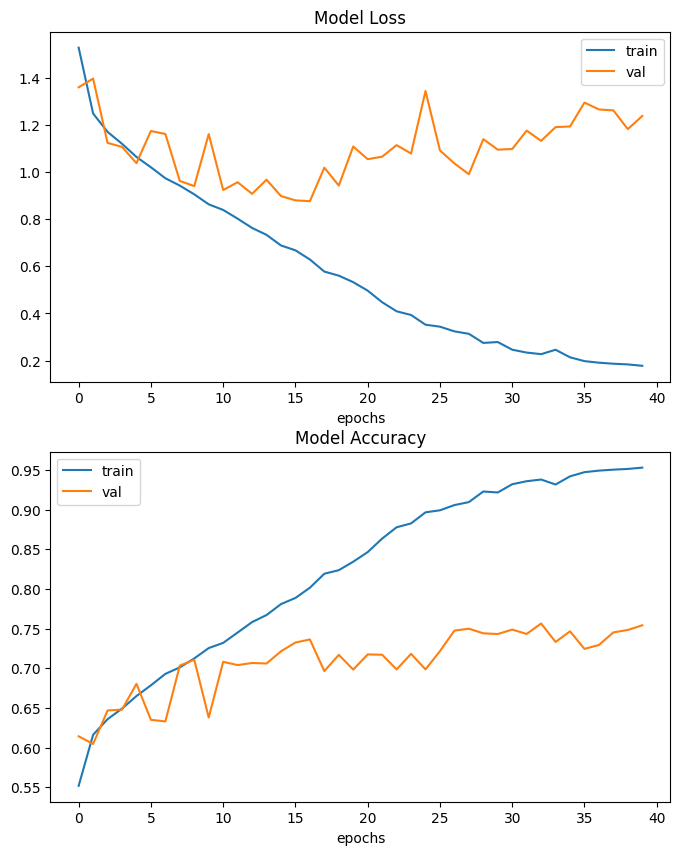

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(8, 10))
ax = ax.ravel()


ax[0].plot(his_trainloss)
ax[0].plot(his_valloss)
ax[0].set_title("Model {}".format("Loss"))
ax[0].set_xlabel("epochs")
ax[0].legend(["train", "val"])

ax[1].plot(his_trainacc)
ax[1].plot(his_valacc)
ax[1].set_title("Model {}".format("Accuracy"))
ax[1].set_xlabel("epochs")
# ax[1].set_ylabel(metric)
ax[1].legend(["train", "val"])

## 六、模型预测
来自模型的原始预测表示一个热编码的形状张量，其中20个通道中的每一个都是对应于预测标签的二进制掩码。
为了可视化结果，我们将其绘制为RGB掩模，其中每个像素由对应于预测的特定标签的唯一颜色表示。我们可以很容易地从作为数据集一部分提供的文件中找到每个标签对应的颜色。我们还将在输入图像上绘制RGB分割掩模的覆盖图，因为这可以进一步帮助我们更直观地识别图像中存在的不同类别。*（N，51251220）humancolormap.mat*

In [63]:
colormap = loadmat(
    "./instance-level_human_parsing/human_colormap.mat"
)["colormap"]
colormap = colormap * 255
colormap = colormap.astype(np.uint8)

def decode_segmentation_masks(mask, colormap, n_classes):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    for l in range(0, n_classes):
        idx = mask == l
        r[idx] = colormap[l, 0]
        g[idx] = colormap[l, 1]
        b[idx] = colormap[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb

def get_overlay(image, colored_mask):
    overlay = cv2.addWeighted(image, 0.35, colored_mask, 0.65, 0)
    return overlay

def preshow(path):
    plt.figure(figsize=(10, 10))
    i = 0
    mask_idx = 0
    param_state_dict = paddle.load( "bestmodel")
    cnn.set_dict(param_state_dict)
    cnn.eval() #预测模式
    with open(path, 'r') as f:
        for line in f.readlines():
            if i > 8: 
                break

            image_path, label_path = line.strip().split('\t')
            resize_t = T.Compose([           
                T.Transpose(), 
                T.Normalize(mean=127.5, std=127.5)
            ])
            image = PilImage.open(image_path)
            label = PilImage.open(label_path)
            
            image = np.array(image).astype('uint8')
            label = np.array(label).astype('uint8')

            cimg = np.expand_dims(resize_t(image),axis=0)
            data = cnn(paddle.to_tensor(cimg))[0][0]
            mask = np.argmax(data, axis=0)
   
            prediction_colormap = decode_segmentation_masks(mask, colormap, 20)
            overlay = get_overlay(image, prediction_colormap)

            
            plt.subplot(3, 3, i + 1)
            plt.imshow(image)
            plt.axis("off")

            plt.subplot(3, 3, i + 2)
            plt.imshow(overlay)
            plt.axis("off")
                   
            plt.subplot(3, 3, i + 3)
            plt.imshow(prediction_colormap)
            plt.axis("off")
            i += 3
            mask_idx += 1

    plt.show()

### 训练集展示

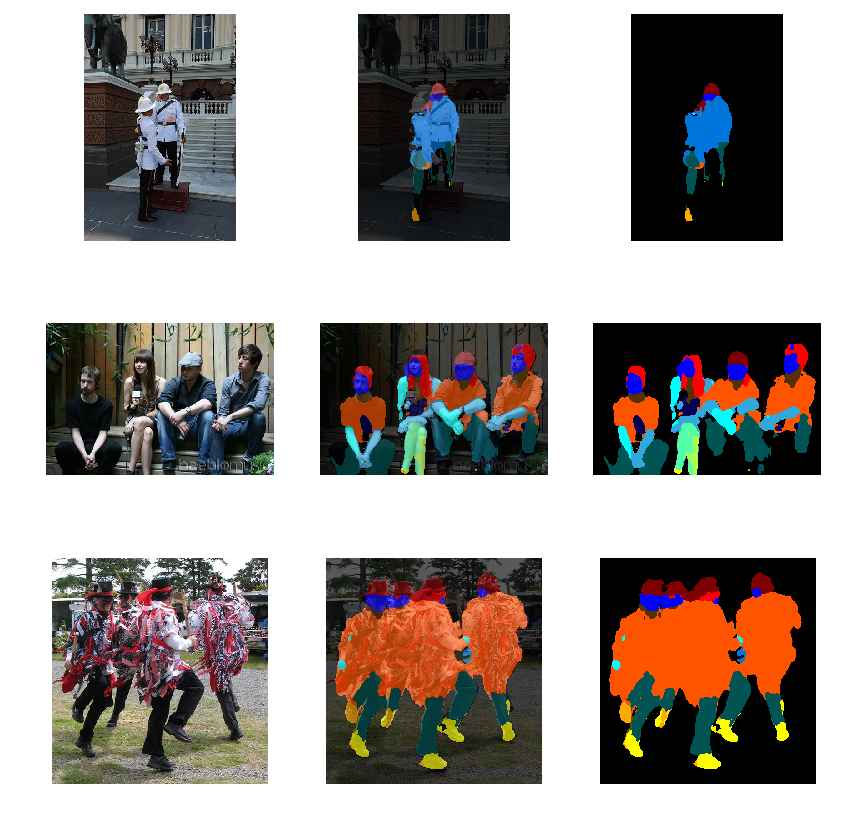

In [64]:
preshow('./train.txt')

### 验证集展示

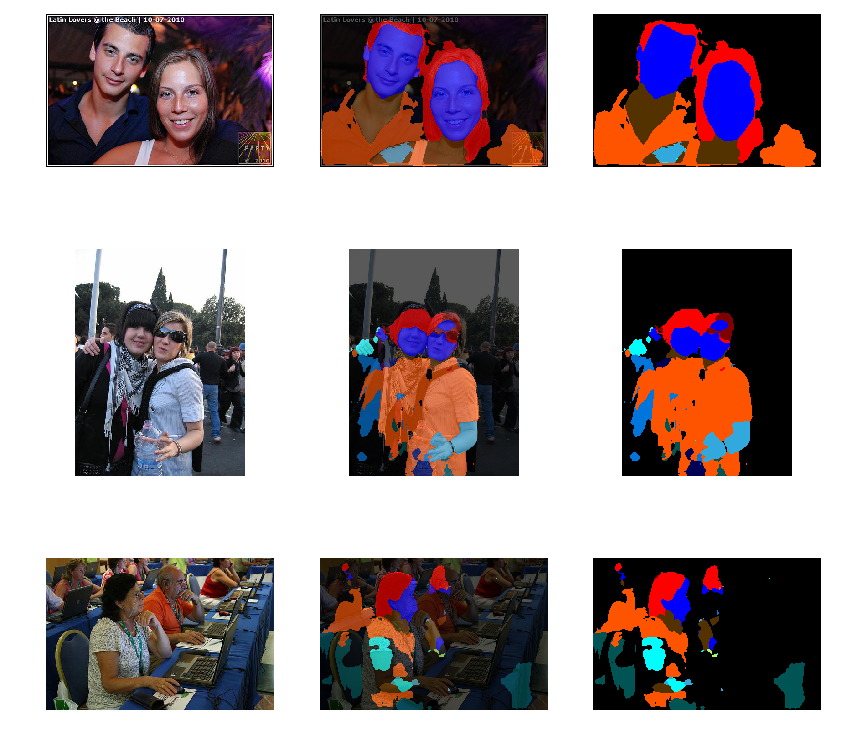

In [65]:
preshow('./val.txt')